#what is this notebook?
In This notebook, we are trynig to find stable modules by using the Louvain community detection algorithm.

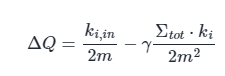

#imports and uplode

In [9]:
! pip install bctpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.4/110.4 kB 3.4 MB/s eta 0:00:00


In [10]:
from google.colab import files
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import normalized_mutual_info_score
import bct

In [2]:
# Upload CSV file to the Colab, data is the main dataset.
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

Saving preprocessed_data.csv to preprocessed_data.csv


In [39]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
modules = pd.read_csv(file_name)

Saving real-labels.csv to real-labels.csv


In [40]:
modules = np.array(modules)
module_li = modules.T[2]
arr_numeric = np.array(module_li, dtype=float)
module_list = np.where(np.isnan(arr_numeric), 18, arr_numeric)

In [5]:
#making the binarized network

text_data = data.iloc[:, 1].astype(str)
vectorizer = CountVectorizer()
vectorized_text = vectorizer.fit_transform(text_data)

cosine_similarity_matrix = cosine_similarity(vectorized_text)
cosine_similarity_matrix1 = cosine_similarity(vectorized_text)-np.eye(np.shape(cosine_similarity_matrix)[0]) #deleteing self loops

def binarizing(x, tr):
  x_bin = np.where(x >= tr, 1, 0)
  return x_bin

mat = binarizing(cosine_similarity_matrix1, 0.02)


#Functions

In [35]:
#making the ensemble of partition with same resolution
def get_partitions(W, gamma, B='modularity', rep=1):
    partitions = []
    modularity = []
    for i in range(rep):
        partition, q = bct.community_louvain(W, gamma=gamma, B=B)
        partitions.append(partition)
        modularity.append(q)
    return partitions, modularity


#finding the best(most similar to other) paritition in the ensemble
def get_best_partition(partitions):

  n = len(partitions)
  sim_mat = np.zeros((n, n))
  sim_array = np.zeros(n)

  for i in range(n):
    for j in range(n):
      sim_mat[i][j] = normalized_mutual_info_score(partitions[i], partitions[j])
    sim_array[i] = np.sum(sim_mat[i])
  max_sim_arg = np.argmax(sim_array)
  return partitions[max_sim_arg]

#Finding the stable modules

[ 21.          21.          21.          21.          21.93333333
  21.8         22.13333333  22.9         23.26666667  24.43333333
  25.53333333  26.83333333  28.66666667  30.33333333  31.96666667
  35.7         40.1         46.6         53.          59.73333333
  67.96666667  77.43333333  90.26666667  99.06666667 111.86666667
 122.         132.03333333 143.         153.53333333 162.36666667]


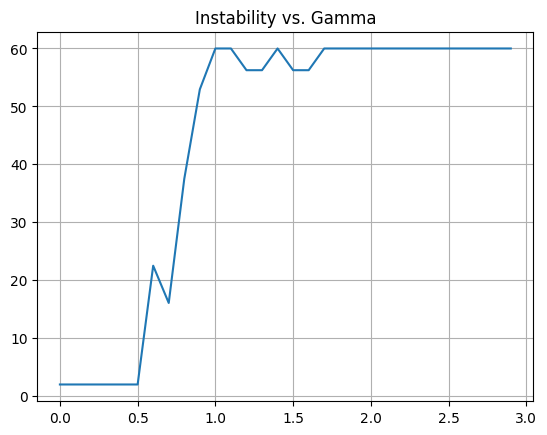

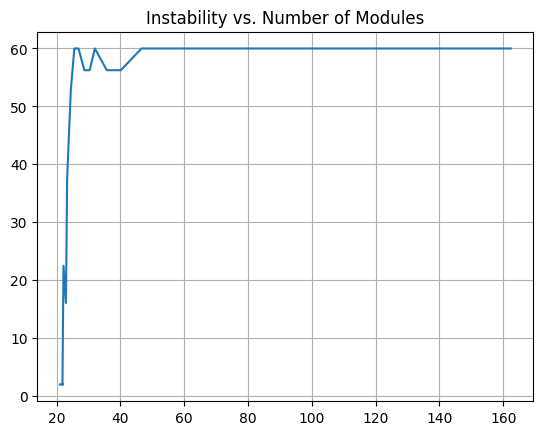

In [37]:
#finding the instability for each modules
rep = 30
count = 0
gamma = np.arange(0, 3, 0.1)
stab = np.zeros(len(gamma))
n_module = np.zeros(len(gamma))
for k in gamma:
  s = np.zeros((rep,rep))
  nm = 0
  partitions, q = get_partitions(mat, k,'negative_asym', rep=rep)
  for i in range(rep):
    nm = nm + len(set(partitions[i]))
    for j in range(rep):
      if normalized_mutual_info_score(partitions[i], partitions[j])>0.95:
        s[i][j] = 1

  stab[count] = (0.5*np.sum(s))/(rep*rep)
  n_module[count] = nm/rep
  count = count + 1

print(n_module)
plt.plot(gamma, 1/stab)
plt.grid(True)
plt.title('Instability vs. Gamma')
plt.show()

plt.plot(n_module, 1/stab)
plt.grid(True)
plt.title('Instability vs. Number of Modules')
plt.show()

Text(0, 0.5, 'Module number')

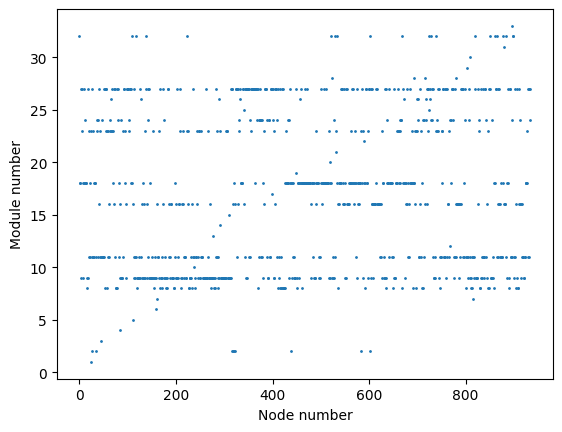

In [38]:
#use one of the stable gamma for the modules
partitions, q = get_partitions(mat, 1.3,'negative_asym', rep=100)
partition = get_best_partition(partitions)

node = np.arange(np.shape(mat)[0])
plt.scatter(node, partition, s = 1)
plt.xlabel('Node number')
plt.ylabel('Module number')

#some other properties

In [41]:
from sklearn.metrics.cluster import normalized_mutual_info_score

normalized_mutual_info_score(partition, module_list)

0.14014110265732807

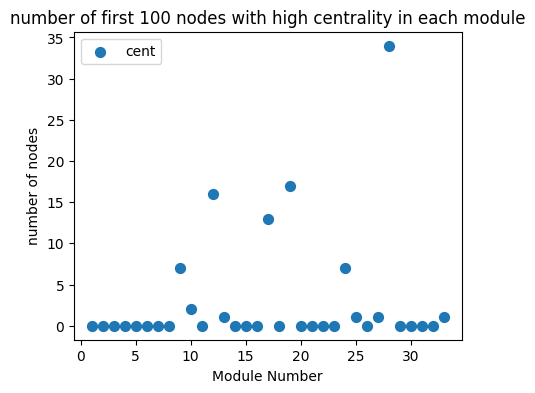

In [43]:
g = nx.from_numpy_array(mat)
cent = nx.eigenvector_centrality(g)
n = len(set(partition))
def sorting(Y):
  sorted_cent = sorted(cent.items(), key=lambda x: x[1], reverse=True)
  top= sorted_cent[:Y]
  counter = np.zeros(n)
  s = np.zeros(n)
  for i in range(Y):
    for k in range(n):
      if partition[top[i][0]] == k:
        counter[k] = counter[k] + 1
  return counter

node = np.linspace(1,n,n)
plt.figure(figsize=(5, 4))
len_modules = np.zeros(len(set(module_list)))

y = 100
plt.scatter(node, sorting(y), label = 'cent', s=50)
plt.title('number of first 100 nodes with high centrality in each module')
plt.xlabel('Module Number')
plt.ylabel('number of nodes')
plt.legend()
plt.show()

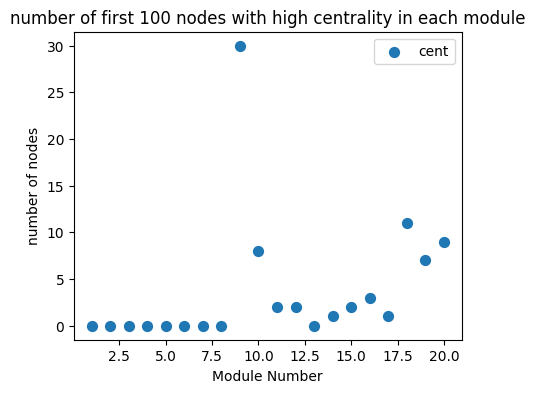

In [45]:
g = nx.from_numpy_array(mat)
cent = nx.eigenvector_centrality(g)
n = len(set(module_list))
def sorting(Y):
  sorted_cent = sorted(cent.items(), key=lambda x: x[1], reverse=True)
  top= sorted_cent[:Y]
  counter = np.zeros(n)
  s = np.zeros(n)
  for i in range(Y):
    for k in range(n):
      if module_list[top[i][0]] == k:
        counter[k] = counter[k] + 1
  return counter

node = np.linspace(1,n,n)
plt.figure(figsize=(5, 4))
len_modules = np.zeros(len(set(module_list)))

y = 100
plt.scatter(node, sorting(y), label = 'cent', s=50)
plt.title('number of first 100 nodes with high centrality in each module')
plt.xlabel('Module Number')
plt.ylabel('number of nodes')
plt.legend()
plt.show()